# About this notebook

Siamese and contrastive loss can be used for signature verification by training a Siamese neural network to differentiate between genuine and forged signatures. The network consists of two identical branches, one for each of the two signatures being compared. The output of the two branches is then fed into a contrastive loss function, which calculates the difference between the two signatures and penalizes the network if the difference is too small (indicating that the signatures are likely to be genuine) or too large (indicating that the signatures are likely to be forged).

To improve the performance of the network, it is important to preprocess the signatures before training. This can include removing the background, centering the signature in a canvas, and resizing the signature to a fixed size (such as 170x242). These preprocessing steps can help to standardize the input to the network and make it easier for the network to learn the features that are important for signature verification.

# Acknowledgment
- This [link](https://github.com/luizgh/sigver) has the pretrained weights I used for my model. I also took the preprocessing functions.

# Load data

In [1]:
import os
os.environ["WANDB_MODE"] = "disabled"


In [2]:
import pandas as pd
# Train data
train = pd.read_csv('../input/signature-verification-dataset/sign_data/train_data.csv')
train.rename(columns={"1":"label"}, inplace=True)
train["image_real_paths"] = train["068/09_068.png"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/train/{x}")
train["image_forged_paths"] = train["068_forg/03_0113068.PNG"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/train/{x}")

# Test data
test = pd.read_csv('../input/signature-verification-dataset/sign_data/test_data.csv')
test.rename(columns={"1":"label"}, inplace=True)
test["image_real_paths"] = test["068/09_068.png"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/test/{x}")
test["image_forged_paths"] = test["068_forg/03_0113068.PNG"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/test/{x}")

In [3]:
train["label"].value_counts(normalize=True)

0    0.543073
1    0.456927
Name: label, dtype: float64

In [4]:
test["label"].value_counts(normalize=True)

1    0.517661
0    0.482339
Name: label, dtype: float64

# Directory

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Configuration

In [6]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    size=128
    num_workers=2
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=20
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':4,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':3,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3,
        'steps_per_epoch':7, 
        'epochs':7
    }
    batch_size=32
    lr=1e-3
    weight_decay=1e-3
    canvas_size = (952, 1360)
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_size=train["label"].shape[0]
    nfolds=5
    trn_folds=[0]
    model_name='convnet'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d' 'tresnet_m'
    train=True
    early_stop=True
    target_col="label"
    projection2d=True
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=42
    
if CFG.debug:
    CFG.epochs=1
    train=train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Libraries

In [7]:
import pandas as pd
import numpy as np
import wandb
from skimage import filters, transform
from skimage.io import imread
from skimage import img_as_ubyte
from typing import Tuple

# ====================================================
# Library
# ====================================================
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict


import scipy as sp

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform


from torch.cuda.amp import autocast, GradScaler

# Functions for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# W&B

In [11]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_key")

import wandb
wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="Signature", 
                 name="convnet",
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

# utils

In [12]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = accuracy_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# Data Pre-processing

In [13]:
def preprocess_signature(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] =(170, 242),
                         input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    """ Pre-process a signature image, centering it in a canvas, resizing the image and cropping it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The signature image
    canvas_size : tuple (H x W)
        The size of a canvas where the signature will be centered on.
        Should be larger than the signature.
    img_size : tuple (H x W)
        The size that will be used to resize (rescale) the signature
    input_size : tuple (H x W)
        The final size of the signature, obtained by croping the center of image.
        This is necessary in cases where data-augmentation is used, and the input
        to the neural network needs to have a slightly smaller size.
    Returns
    -------
    np.narray (input_size):
        The pre-processed image
    -------
    """
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped


def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
    """ Centers an image in a pre-defined canvas size, and remove
    noise using OTSU's method.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be processed
    canvas_size : tuple (H x W)
        The desired canvas size
    Returns
    -------
    np.ndarray (H x W)
        The normalized image
    """

    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]

    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image


def remove_background(img: np.ndarray) -> np.ndarray:
        """ Remove noise using OTSU's method.
        Parameters
        ----------
        img : np.ndarray
            The image to be processed
        Returns
        -------
        np.ndarray
            The image with background removed
        """

        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
        threshold = filters.threshold_otsu(img)

        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img


def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    """ Crops an image to the desired size without stretching it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be cropped
    size : tuple (H x W)
        The desired size
    Returns
    -------
    np.ndarray
        The cropped image
    """
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]


def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of an image
        Parameters
        ----------
        img : np.ndarray (H x W)
            The image to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray
            The cRecentropped image
        """
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped


def crop_center_multiple(imgs: np.ndarray,
                         size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of multiple images
        Parameters
        ----------
        imgs : np.ndarray (N x C x H_old x W_old)
            The images to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray (N x C x H x W)
            The cropped images
        """
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

def imshow(img, text=None, save=False):
    npimg = img.numpy()
    plt.axis('off')

    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    #plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray')
    plt.imshow(npimg[1, :, :])
    plt.show()

def show_plot(iteration, loss):
    plt.plt(iteration, loss)
    plt.show()

In [14]:
canvas_size = (952, 1360)
img_size = (128, 128)
input_size = (256, 256)

observation = train.iloc[10]
img1 = load_signature(observation["image_real_paths"])
img2 = load_signature(observation["image_forged_paths"])
preprocessed_img1 = preprocess_signature(img1, canvas_size, input_size)
preprocessed_img2 = preprocess_signature(img2, canvas_size, input_size)

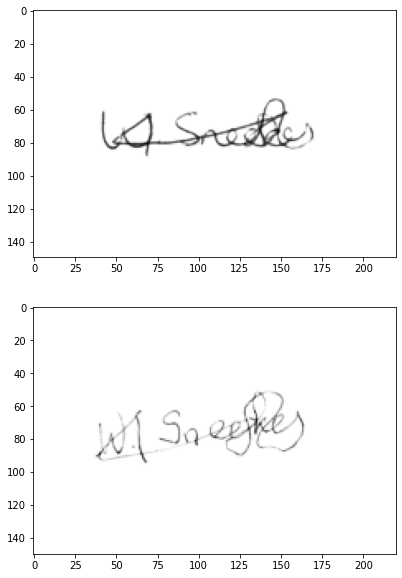

In [15]:
# Shows pre-processed samples of the two users

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(preprocessed_img1)
ax[1].imshow(preprocessed_img2)

# Dataaset

In [16]:
class SignatureDataset(Dataset):
    
    def __init__(self, df, canvas_size, dim=(256, 256)):
        self.df  = df
        self.real_file_names = df["image_real_paths"].values
        self.forged_file_names = df["image_forged_paths"].values
        self.labels = df["label"].values
        self.dim = dim
        self.canvas_size=canvas_size

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,index):
        # getting the image path
        real_file_path = self.real_file_names[index]
        forged_file_path = self.forged_file_names[index]
        
        img1 = load_signature(real_file_path)
        img2 = load_signature(forged_file_path)
        
        img1 = preprocess_signature(img1, canvas_size, self.dim)
        img2 = preprocess_signature(img2, canvas_size, self.dim)
        
        label = torch.tensor(self.labels[index], dtype=torch.long)
        
        return torch.tensor(img1), torch.tensor(img2), label.float()

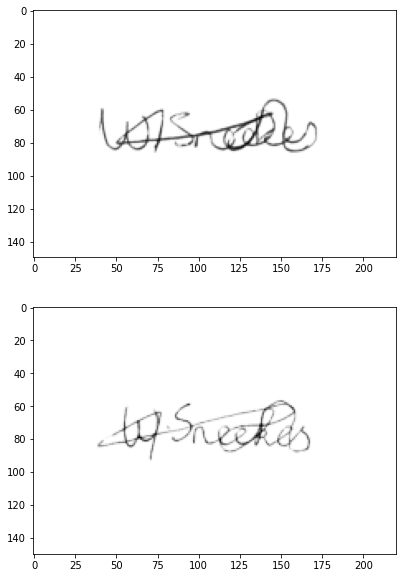

In [17]:
train_dataset = SignatureDataset(train, canvas_size, input_size)
img1, img2, _ = train_dataset[1]

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(img1)
ax[1].imshow(img2)

# Contrastive loss

In [18]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.cosine_similarity(F.normalize(output1), F.normalize(output2))
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Models

In [19]:
class SigNet(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SigNet, self).__init__()

        self.feature_space_size = 2048

        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', conv_bn_mish(1, 96, 11, stride=4)),
            ('maxpool1', nn.MaxPool2d(3, 2)),
            ('conv2', conv_bn_mish(96, 256, 5, pad=2)),
            ('maxpool2', nn.MaxPool2d(3, 2)),
            ('conv3', conv_bn_mish(256, 384, 3, pad=1)),
            ('conv4', conv_bn_mish(384, 384, 3, pad=1)),
            ('conv5', conv_bn_mish(384, 256, 3, pad=1)),
            ('maxpool3', nn.MaxPool2d(3, 2)),
        ]))

        self.fc_layers = nn.Sequential(OrderedDict([
            ('fc1', linear_bn_mish(256 * 3 * 5, 2048)),
            ('fc2', linear_bn_mish(self.feature_space_size, self.feature_space_size)),
        ]))
    
    def forward_once(self, img):
        x = self.conv_layers(img)
        x = x.view(x.shape[0], 256 * 3 * 5)
        x = self.fc_layers(x)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        # forward pass of input 1
        output1 = self.forward_once(img1)
        # forward pass of input 2
        output2 = self.forward_once(img2)
        return output1, output2


def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('mish', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('mish', nn.Mish()),
    ]))

class SiameseModel(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SiameseModel, self).__init__()

        self.model = SigNet()
        state_dict, _, _ = torch.load("../input/pretrained-signature-weights/signet.pth")
        self.model.load_state_dict(state_dict)
        
        if CFG.projection2d:
            self.probs = nn.Linear(4, 1)
        else:
            self.probs = nn.Linear(self.model.feature_space_size*2, 1)
        self.projection2d = nn.Linear(self.model.feature_space_size, 2)
    
    def forward_once(self, img):
        x = self.model.forward_once(img)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        # forward pass of input 1
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        embedding1 = self.forward_once(img1)
        # forward pass of input 2
        embedding2 = self.forward_once(img2)
        
        if CFG.projection2d:
            #print("Project embeddings into 2d space")
            embedding1 = self.projection2d(embedding1)
            embedding2 = self.projection2d(embedding2)
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            output= self.probs(output)
            return embedding1, embedding2, output
        else:
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            print(output.shape)
            output= self.probs(output)
            return embedding1, embedding2, output

# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterions, optimizer, epoch, scheduler, device):
    
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (img1, img2, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        img1 = img1.to(device).float()
        img2 = img2.to(device).float()
        labels = labels.to(device)
        batch_size = labels.size(0)
        out1, out2, preds = model(img1, img2)
        loss1 = criterions[0](out1, out2, labels)
        loss2 = criterions[1](preds.squeeze(1), labels)
        loss = (loss1 + loss2) / 2
            
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print(f'Epoch: [{epoch}][{step}/{len(train_loader)}] ', end='')
            print(f'Elapsed: {timeSince(start, float(step+1)/len(train_loader))} ', end='')
            print(f'Loss: {losses.val:.4f}({losses.avg:.4f}) ', end='')
            print(f'Grad: {grad_norm:.4f} ', end='')
            if scheduler:
                print(f'LR: {scheduler.get_last_lr()[0]:.6f}  ')
            else:
                print(f'LR: {CFG.lr}')
            
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_last_lr()[0]})
    return losses.avg

# train

In [23]:
# ====================================================
# loader
# ====================================================
seed_torch(seed=CFG.seed)


train_dataset = SignatureDataset(train, CFG.canvas_size, dim=(256, 256))

train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
   
# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='OneCycleLR':
        scheduler = OneCycleLR(optimizer, **CFG.onecycle_params)
    return scheduler

# ====================================================
# model & optimizer
# ====================================================
model = SiameseModel()
model.to(device)
    

optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
try:
    scheduler = get_scheduler(optimizer)
except:
    print('Learning scheduler is not used')

# ====================================================
# loop
# ====================================================
contrastive = ContrastiveLoss() # Contrastive loss
binary_cross = nn.BCEWithLogitsLoss() # Binary cross entropy
best_score = 0.
best_loss = np.inf
    
for epoch in range(CFG.epochs):
        
    start_time = time.time()
        
    # train
    avg_loss = train_fn(train, train_loader, model, [contrastive, binary_cross], optimizer, epoch, scheduler, device)

        
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, OneCycleLR):
        scheduler.step()


    elapsed = time.time() - start_time

    LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
    wandb.log({f"epoch": epoch+1, 
                   f"avg_train_loss": avg_loss})
                 
            
    if avg_loss < best_loss:
        best_loss = avg_loss
        LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save({'model': model.state_dict()}, 
                        OUTPUT_DIR+f'{CFG.model_name}_best_loss.pt')
   
   
wandb.finish()    

Epoch: [0][0/725] Elapsed: 0m 3s (remain 37m 15s) Loss: 0.7075(0.7075) Grad: 40.1925 LR: 0.001000  
Epoch: [0][100/725] Elapsed: 2m 17s (remain 14m 8s) Loss: 0.5148(0.6124) Grad: 1.2615 LR: 0.001000  
Epoch: [0][200/725] Elapsed: 4m 34s (remain 11m 56s) Loss: 0.3927(0.5313) Grad: 1.2460 LR: 0.001000  
Epoch: [0][300/725] Elapsed: 6m 49s (remain 9m 36s) Loss: 0.1664(0.4491) Grad: 0.9199 LR: 0.001000  
Epoch: [0][400/725] Elapsed: 9m 4s (remain 7m 20s) Loss: 0.0931(0.3787) Grad: 0.8602 LR: 0.001000  
Epoch: [0][500/725] Elapsed: 11m 17s (remain 5m 2s) Loss: 0.0278(0.3201) Grad: 0.3124 LR: 0.001000  
Epoch: [0][600/725] Elapsed: 13m 29s (remain 2m 46s) Loss: 0.0133(0.2784) Grad: 0.2147 LR: 0.001000  
Epoch: [0][700/725] Elapsed: 15m 42s (remain 0m 32s) Loss: 0.0816(0.2461) Grad: 1.1421 LR: 0.001000  


Epoch 1 - avg_train_loss: 0.2391  time: 975s
Epoch 1 - Save Best Loss: 0.2391 Model


Epoch: [0][724/725] Elapsed: 16m 14s (remain 0m 0s) Loss: 0.0139(0.2391) Grad: 0.2312 LR: 0.001000  
Epoch: [1][0/725] Elapsed: 0m 2s (remain 35m 54s) Loss: 0.0245(0.0245) Grad: 0.6377 LR: 0.000855  
Epoch: [1][100/725] Elapsed: 2m 19s (remain 14m 24s) Loss: 0.0505(0.0397) Grad: 0.6348 LR: 0.000855  
Epoch: [1][200/725] Elapsed: 4m 36s (remain 12m 1s) Loss: 0.0351(0.0396) Grad: 0.7588 LR: 0.000855  
Epoch: [1][300/725] Elapsed: 6m 52s (remain 9m 41s) Loss: 0.0392(0.0380) Grad: 0.5117 LR: 0.000855  
Epoch: [1][400/725] Elapsed: 9m 7s (remain 7m 22s) Loss: 0.0100(0.0340) Grad: 0.0804 LR: 0.000855  
Epoch: [1][500/725] Elapsed: 11m 42s (remain 5m 14s) Loss: 0.0336(0.0357) Grad: 0.8695 LR: 0.000855  
Epoch: [1][600/725] Elapsed: 14m 2s (remain 2m 53s) Loss: 0.0547(0.0358) Grad: 1.0611 LR: 0.000855  
Epoch: [1][700/725] Elapsed: 16m 18s (remain 0m 33s) Loss: 0.0121(0.0349) Grad: 0.1354 LR: 0.000855  


Epoch 2 - avg_train_loss: 0.0344  time: 1013s
Epoch 2 - Save Best Loss: 0.0344 Model


Epoch: [1][724/725] Elapsed: 16m 52s (remain 0m 0s) Loss: 0.0086(0.0344) Grad: 0.0793 LR: 0.000855  
Epoch: [2][0/725] Elapsed: 0m 2s (remain 36m 10s) Loss: 0.0095(0.0095) Grad: 0.1108 LR: 0.000505  
Epoch: [2][100/725] Elapsed: 2m 19s (remain 14m 19s) Loss: 0.0097(0.0136) Grad: 0.0998 LR: 0.000505  
Epoch: [2][200/725] Elapsed: 4m 32s (remain 11m 50s) Loss: 0.0074(0.0125) Grad: 0.0421 LR: 0.000505  
Epoch: [2][300/725] Elapsed: 6m 49s (remain 9m 36s) Loss: 0.0127(0.0125) Grad: 0.1935 LR: 0.000505  
Epoch: [2][400/725] Elapsed: 9m 7s (remain 7m 22s) Loss: 0.0070(0.0123) Grad: 0.0443 LR: 0.000505  
Epoch: [2][500/725] Elapsed: 11m 19s (remain 5m 4s) Loss: 0.0069(0.0120) Grad: 0.0579 LR: 0.000505  
Epoch: [2][600/725] Elapsed: 13m 34s (remain 2m 48s) Loss: 0.0163(0.0146) Grad: 0.3829 LR: 0.000505  
Epoch: [2][700/725] Elapsed: 15m 51s (remain 0m 32s) Loss: 0.0151(0.0152) Grad: 0.4271 LR: 0.000505  


Epoch 3 - avg_train_loss: 0.0152  time: 984s
Epoch 3 - Save Best Loss: 0.0152 Model


Epoch: [2][724/725] Elapsed: 16m 23s (remain 0m 0s) Loss: 0.0161(0.0152) Grad: 0.2299 LR: 0.000505  
Epoch: [3][0/725] Elapsed: 0m 2s (remain 33m 38s) Loss: 0.0096(0.0096) Grad: 0.1111 LR: 0.000155  
Epoch: [3][100/725] Elapsed: 2m 14s (remain 13m 52s) Loss: 0.0093(0.0110) Grad: 0.1331 LR: 0.000155  
Epoch: [3][200/725] Elapsed: 4m 25s (remain 11m 32s) Loss: 0.0074(0.0115) Grad: 0.1091 LR: 0.000155  
Epoch: [3][300/725] Elapsed: 6m 40s (remain 9m 23s) Loss: 0.0069(0.0108) Grad: 0.0470 LR: 0.000155  
Epoch: [3][400/725] Elapsed: 8m 54s (remain 7m 12s) Loss: 0.0150(0.0108) Grad: 0.3159 LR: 0.000155  
Epoch: [3][500/725] Elapsed: 11m 8s (remain 4m 58s) Loss: 0.0088(0.0104) Grad: 0.1588 LR: 0.000155  
Epoch: [3][600/725] Elapsed: 13m 22s (remain 2m 45s) Loss: 0.0082(0.0105) Grad: 0.1154 LR: 0.000155  
Epoch: [3][700/725] Elapsed: 15m 34s (remain 0m 31s) Loss: 0.0098(0.0101) Grad: 0.1374 LR: 0.000155  


Epoch 4 - avg_train_loss: 0.0101  time: 966s
Epoch 4 - Save Best Loss: 0.0101 Model


Epoch: [3][724/725] Elapsed: 16m 5s (remain 0m 0s) Loss: 0.0067(0.0101) Grad: 0.0894 LR: 0.000155  
Epoch: [4][0/725] Elapsed: 0m 2s (remain 34m 37s) Loss: 0.0066(0.0066) Grad: 0.1033 LR: 0.000010  
Epoch: [4][100/725] Elapsed: 2m 14s (remain 13m 52s) Loss: 0.0055(0.0090) Grad: 0.0349 LR: 0.000010  
Epoch: [4][200/725] Elapsed: 4m 29s (remain 11m 43s) Loss: 0.0056(0.0082) Grad: 0.0579 LR: 0.000010  
Epoch: [4][300/725] Elapsed: 6m 40s (remain 9m 23s) Loss: 0.0060(0.0087) Grad: 0.1062 LR: 0.000010  
Epoch: [4][400/725] Elapsed: 8m 51s (remain 7m 9s) Loss: 0.0061(0.0085) Grad: 0.0351 LR: 0.000010  
Epoch: [4][500/725] Elapsed: 11m 4s (remain 4m 56s) Loss: 0.0060(0.0081) Grad: 0.0528 LR: 0.000010  
Epoch: [4][600/725] Elapsed: 13m 16s (remain 2m 44s) Loss: 0.0064(0.0080) Grad: 0.1423 LR: 0.000010  
Epoch: [4][700/725] Elapsed: 15m 27s (remain 0m 31s) Loss: 0.0055(0.0078) Grad: 0.0339 LR: 0.000010  


Epoch 5 - avg_train_loss: 0.0077  time: 959s
Epoch 5 - Save Best Loss: 0.0077 Model


Epoch: [4][724/725] Elapsed: 15m 58s (remain 0m 0s) Loss: 0.0062(0.0077) Grad: 0.1200 LR: 0.000010  
Epoch: [5][0/725] Elapsed: 0m 2s (remain 33m 32s) Loss: 0.0058(0.0058) Grad: 0.0479 LR: 0.000155  
Epoch: [5][100/725] Elapsed: 2m 13s (remain 13m 44s) Loss: 0.0078(0.0081) Grad: 0.1650 LR: 0.000155  
Epoch: [5][200/725] Elapsed: 4m 24s (remain 11m 29s) Loss: 0.0073(0.0098) Grad: 0.0640 LR: 0.000155  
Epoch: [5][300/725] Elapsed: 6m 36s (remain 9m 18s) Loss: 0.0059(0.0102) Grad: 0.0596 LR: 0.000155  
Epoch: [5][400/725] Elapsed: 8m 52s (remain 7m 9s) Loss: 0.0058(0.0096) Grad: 0.0866 LR: 0.000155  
Epoch: [5][500/725] Elapsed: 11m 7s (remain 4m 58s) Loss: 0.0059(0.0095) Grad: 0.0795 LR: 0.000155  
Epoch: [5][600/725] Elapsed: 13m 25s (remain 2m 46s) Loss: 0.0134(0.0098) Grad: 0.6566 LR: 0.000155  
Epoch: [5][700/725] Elapsed: 15m 41s (remain 0m 32s) Loss: 0.0115(0.0103) Grad: 0.1845 LR: 0.000155  


Epoch 6 - avg_train_loss: 0.0104  time: 974s


Epoch: [5][724/725] Elapsed: 16m 14s (remain 0m 0s) Loss: 0.0073(0.0104) Grad: 0.1145 LR: 0.000155  
Epoch: [6][0/725] Elapsed: 0m 2s (remain 33m 52s) Loss: 0.0068(0.0068) Grad: 0.1582 LR: 0.000505  
Epoch: [6][100/725] Elapsed: 2m 17s (remain 14m 11s) Loss: 0.0429(0.0853) Grad: 1.4335 LR: 0.000505  
Epoch: [6][200/725] Elapsed: 4m 32s (remain 11m 49s) Loss: 0.0113(0.0618) Grad: 0.2057 LR: 0.000505  
Epoch: [6][300/725] Elapsed: 6m 48s (remain 9m 35s) Loss: 0.0114(0.0485) Grad: 0.2513 LR: 0.000505  
Epoch: [6][400/725] Elapsed: 9m 1s (remain 7m 17s) Loss: 0.0062(0.0393) Grad: 0.1033 LR: 0.000505  
Epoch: [6][500/725] Elapsed: 11m 15s (remain 5m 1s) Loss: 0.0059(0.0335) Grad: 0.0850 LR: 0.000505  
Epoch: [6][600/725] Elapsed: 13m 28s (remain 2m 46s) Loss: 0.0111(0.0303) Grad: 0.4685 LR: 0.000505  
Epoch: [6][700/725] Elapsed: 15m 40s (remain 0m 32s) Loss: 0.0044(0.0272) Grad: 0.0807 LR: 0.000505  


Epoch 7 - avg_train_loss: 0.0266  time: 972s


Epoch: [6][724/725] Elapsed: 16m 12s (remain 0m 0s) Loss: 0.0068(0.0266) Grad: 0.2025 LR: 0.000505  
Epoch: [7][0/725] Elapsed: 0m 2s (remain 33m 19s) Loss: 0.0053(0.0053) Grad: 0.0705 LR: 0.000855  
Epoch: [7][100/725] Elapsed: 2m 13s (remain 13m 46s) Loss: 0.0112(0.0173) Grad: 0.3365 LR: 0.000855  
Epoch: [7][200/725] Elapsed: 4m 28s (remain 11m 40s) Loss: 0.0106(0.0355) Grad: 0.3306 LR: 0.000855  
Epoch: [7][300/725] Elapsed: 6m 43s (remain 9m 28s) Loss: 0.0177(0.0374) Grad: 0.9943 LR: 0.000855  
Epoch: [7][400/725] Elapsed: 8m 56s (remain 7m 13s) Loss: 0.0073(0.0333) Grad: 0.2146 LR: 0.000855  
Epoch: [7][500/725] Elapsed: 11m 8s (remain 4m 59s) Loss: 0.1803(0.0294) Grad: 2.2543 LR: 0.000855  
Epoch: [7][600/725] Elapsed: 13m 20s (remain 2m 45s) Loss: 0.0131(0.0277) Grad: 0.2768 LR: 0.000855  
Epoch: [7][700/725] Elapsed: 15m 32s (remain 0m 31s) Loss: 0.0082(0.0273) Grad: 0.1013 LR: 0.000855  


Epoch 8 - avg_train_loss: 0.0267  time: 963s


Epoch: [7][724/725] Elapsed: 16m 3s (remain 0m 0s) Loss: 0.0229(0.0267) Grad: 0.4877 LR: 0.000855  
Epoch: [8][0/725] Elapsed: 0m 2s (remain 34m 16s) Loss: 0.0050(0.0050) Grad: 0.0637 LR: 0.001000  
Epoch: [8][100/725] Elapsed: 2m 13s (remain 13m 42s) Loss: 0.0170(0.0099) Grad: 0.9149 LR: 0.001000  
Epoch: [8][200/725] Elapsed: 4m 25s (remain 11m 33s) Loss: 0.0052(0.0198) Grad: 0.1805 LR: 0.001000  
Epoch: [8][300/725] Elapsed: 6m 38s (remain 9m 20s) Loss: 0.0098(0.0221) Grad: 0.2324 LR: 0.001000  
Epoch: [8][400/725] Elapsed: 8m 51s (remain 7m 9s) Loss: 0.0060(0.0190) Grad: 0.1261 LR: 0.001000  
Epoch: [8][500/725] Elapsed: 11m 8s (remain 4m 58s) Loss: 0.0066(0.0167) Grad: 0.1600 LR: 0.001000  
Epoch: [8][600/725] Elapsed: 13m 21s (remain 2m 45s) Loss: 0.0136(0.0173) Grad: 0.5694 LR: 0.001000  
Epoch: [8][700/725] Elapsed: 15m 33s (remain 0m 31s) Loss: 0.0111(0.0160) Grad: 0.5455 LR: 0.001000  


Epoch 9 - avg_train_loss: 0.0157  time: 965s


Epoch: [8][724/725] Elapsed: 16m 5s (remain 0m 0s) Loss: 0.0038(0.0157) Grad: 0.0764 LR: 0.001000  
Epoch: [9][0/725] Elapsed: 0m 2s (remain 34m 57s) Loss: 0.0035(0.0035) Grad: 0.0791 LR: 0.000855  
Epoch: [9][100/725] Elapsed: 2m 15s (remain 13m 58s) Loss: 0.0044(0.0053) Grad: 0.1007 LR: 0.000855  
Epoch: [9][200/725] Elapsed: 4m 26s (remain 11m 33s) Loss: 0.0032(0.0049) Grad: 0.0967 LR: 0.000855  
Epoch: [9][300/725] Elapsed: 6m 37s (remain 9m 20s) Loss: 0.0081(0.0049) Grad: 0.3819 LR: 0.000855  
Epoch: [9][400/725] Elapsed: 8m 49s (remain 7m 8s) Loss: 0.0071(0.0067) Grad: 0.2428 LR: 0.000855  
Epoch: [9][500/725] Elapsed: 11m 1s (remain 4m 55s) Loss: 0.0115(0.0071) Grad: 0.2811 LR: 0.000855  
Epoch: [9][600/725] Elapsed: 13m 14s (remain 2m 43s) Loss: 0.0056(0.0075) Grad: 0.2197 LR: 0.000855  
Epoch: [9][700/725] Elapsed: 15m 26s (remain 0m 31s) Loss: 0.0054(0.0072) Grad: 0.1936 LR: 0.000855  


Epoch 10 - avg_train_loss: 0.0071  time: 958s
Epoch 10 - Save Best Loss: 0.0071 Model


Epoch: [9][724/725] Elapsed: 15m 58s (remain 0m 0s) Loss: 0.0110(0.0071) Grad: 0.6412 LR: 0.000855  
Epoch: [10][0/725] Elapsed: 0m 2s (remain 34m 5s) Loss: 0.0090(0.0090) Grad: 0.3313 LR: 0.000505  
Epoch: [10][100/725] Elapsed: 2m 14s (remain 13m 51s) Loss: 0.0033(0.0040) Grad: 0.0403 LR: 0.000505  
Epoch: [10][200/725] Elapsed: 4m 25s (remain 11m 30s) Loss: 0.0033(0.0040) Grad: 0.0645 LR: 0.000505  
Epoch: [10][300/725] Elapsed: 6m 37s (remain 9m 19s) Loss: 0.0036(0.0037) Grad: 0.1490 LR: 0.000505  
Epoch: [10][400/725] Elapsed: 8m 48s (remain 7m 6s) Loss: 0.0023(0.0037) Grad: 0.0312 LR: 0.000505  
Epoch: [10][500/725] Elapsed: 10m 58s (remain 4m 54s) Loss: 0.0027(0.0036) Grad: 0.0266 LR: 0.000505  
Epoch: [10][600/725] Elapsed: 13m 10s (remain 2m 43s) Loss: 0.0026(0.0036) Grad: 0.0786 LR: 0.000505  
Epoch: [10][700/725] Elapsed: 15m 21s (remain 0m 31s) Loss: 0.0030(0.0037) Grad: 0.0690 LR: 0.000505  


Epoch 11 - avg_train_loss: 0.0037  time: 953s
Epoch 11 - Save Best Loss: 0.0037 Model


Epoch: [10][724/725] Elapsed: 15m 52s (remain 0m 0s) Loss: 0.0033(0.0037) Grad: 0.1104 LR: 0.000505  
Epoch: [11][0/725] Elapsed: 0m 2s (remain 33m 13s) Loss: 0.0034(0.0034) Grad: 0.1357 LR: 0.000155  
Epoch: [11][100/725] Elapsed: 2m 13s (remain 13m 43s) Loss: 0.0026(0.0032) Grad: 0.0446 LR: 0.000155  
Epoch: [11][200/725] Elapsed: 4m 23s (remain 11m 26s) Loss: 0.0030(0.0033) Grad: 0.0486 LR: 0.000155  
Epoch: [11][300/725] Elapsed: 6m 34s (remain 9m 15s) Loss: 0.0024(0.0033) Grad: 0.0342 LR: 0.000155  
Epoch: [11][400/725] Elapsed: 8m 48s (remain 7m 6s) Loss: 0.0025(0.0032) Grad: 0.0473 LR: 0.000155  
Epoch: [11][500/725] Elapsed: 11m 0s (remain 4m 55s) Loss: 0.0035(0.0034) Grad: 0.0468 LR: 0.000155  
Epoch: [11][600/725] Elapsed: 13m 11s (remain 2m 43s) Loss: 0.0027(0.0033) Grad: 0.0875 LR: 0.000155  
Epoch: [11][700/725] Elapsed: 15m 23s (remain 0m 31s) Loss: 0.0027(0.0033) Grad: 0.0786 LR: 0.000155  


Epoch 12 - avg_train_loss: 0.0033  time: 955s
Epoch 12 - Save Best Loss: 0.0033 Model


Epoch: [11][724/725] Elapsed: 15m 54s (remain 0m 0s) Loss: 0.0028(0.0033) Grad: 0.0961 LR: 0.000155  
Epoch: [12][0/725] Elapsed: 0m 2s (remain 34m 57s) Loss: 0.0028(0.0028) Grad: 0.0342 LR: 0.000010  
Epoch: [12][100/725] Elapsed: 2m 12s (remain 13m 39s) Loss: 0.0024(0.0030) Grad: 0.0293 LR: 0.000010  
Epoch: [12][200/725] Elapsed: 4m 23s (remain 11m 27s) Loss: 0.0022(0.0032) Grad: 0.0271 LR: 0.000010  
Epoch: [12][300/725] Elapsed: 6m 33s (remain 9m 14s) Loss: 0.0104(0.0030) Grad: 0.2557 LR: 0.000010  
Epoch: [12][400/725] Elapsed: 8m 44s (remain 7m 3s) Loss: 0.0029(0.0031) Grad: 0.0353 LR: 0.000010  
Epoch: [12][500/725] Elapsed: 10m 55s (remain 4m 52s) Loss: 0.0021(0.0030) Grad: 0.0204 LR: 0.000010  
Epoch: [12][600/725] Elapsed: 13m 6s (remain 2m 42s) Loss: 0.0021(0.0029) Grad: 0.0212 LR: 0.000010  
Epoch: [12][700/725] Elapsed: 15m 16s (remain 0m 31s) Loss: 0.0028(0.0029) Grad: 0.0394 LR: 0.000010  


Epoch 13 - avg_train_loss: 0.0029  time: 948s
Epoch 13 - Save Best Loss: 0.0029 Model


Epoch: [12][724/725] Elapsed: 15m 47s (remain 0m 0s) Loss: 0.0033(0.0029) Grad: 0.0255 LR: 0.000010  
Epoch: [13][0/725] Elapsed: 0m 2s (remain 34m 23s) Loss: 0.0038(0.0038) Grad: 0.0952 LR: 0.000155  
Epoch: [13][100/725] Elapsed: 2m 17s (remain 14m 12s) Loss: 0.0031(0.0042) Grad: 0.1286 LR: 0.000155  
Epoch: [13][200/725] Elapsed: 4m 32s (remain 11m 50s) Loss: 0.0027(0.0036) Grad: 0.1015 LR: 0.000155  
Epoch: [13][300/725] Elapsed: 6m 47s (remain 9m 33s) Loss: 0.0022(0.0035) Grad: 0.0385 LR: 0.000155  
Epoch: [13][400/725] Elapsed: 9m 1s (remain 7m 17s) Loss: 0.0026(0.0034) Grad: 0.0634 LR: 0.000155  
Epoch: [13][500/725] Elapsed: 11m 13s (remain 5m 1s) Loss: 0.0022(0.0034) Grad: 0.0405 LR: 0.000155  
Epoch: [13][600/725] Elapsed: 13m 24s (remain 2m 45s) Loss: 0.0032(0.0033) Grad: 0.0831 LR: 0.000155  
Epoch: [13][700/725] Elapsed: 15m 35s (remain 0m 32s) Loss: 0.0035(0.0033) Grad: 0.1340 LR: 0.000155  


Epoch 14 - avg_train_loss: 0.0033  time: 967s


Epoch: [13][724/725] Elapsed: 16m 7s (remain 0m 0s) Loss: 0.0034(0.0033) Grad: 0.1109 LR: 0.000155  
Epoch: [14][0/725] Elapsed: 0m 2s (remain 34m 0s) Loss: 0.0029(0.0029) Grad: 0.1256 LR: 0.000505  
Epoch: [14][100/725] Elapsed: 2m 13s (remain 13m 46s) Loss: 0.1478(0.1225) Grad: 2.4206 LR: 0.000505  
Epoch: [14][200/725] Elapsed: 4m 23s (remain 11m 27s) Loss: 0.0168(0.0883) Grad: 0.5077 LR: 0.000505  
Epoch: [14][300/725] Elapsed: 6m 34s (remain 9m 16s) Loss: 0.0065(0.0629) Grad: 0.2592 LR: 0.000505  
Epoch: [14][400/725] Elapsed: 8m 49s (remain 7m 7s) Loss: 0.0041(0.0493) Grad: 0.0999 LR: 0.000505  
Epoch: [14][500/725] Elapsed: 11m 0s (remain 4m 55s) Loss: 0.0073(0.0406) Grad: 0.5074 LR: 0.000505  
Epoch: [14][600/725] Elapsed: 13m 13s (remain 2m 43s) Loss: 0.0038(0.0346) Grad: 0.1288 LR: 0.000505  
Epoch: [14][700/725] Elapsed: 15m 27s (remain 0m 31s) Loss: 0.0029(0.0304) Grad: 0.0671 LR: 0.000505  


Epoch 15 - avg_train_loss: 0.0296  time: 959s


Epoch: [14][724/725] Elapsed: 15m 59s (remain 0m 0s) Loss: 0.0250(0.0296) Grad: 0.9989 LR: 0.000505  
Epoch: [15][0/725] Elapsed: 0m 2s (remain 33m 10s) Loss: 0.0061(0.0061) Grad: 0.3531 LR: 0.000855  
Epoch: [15][100/725] Elapsed: 2m 15s (remain 13m 58s) Loss: 0.0037(0.0081) Grad: 0.2165 LR: 0.000855  
Epoch: [15][200/725] Elapsed: 4m 26s (remain 11m 35s) Loss: 0.0441(0.0125) Grad: 3.9135 LR: 0.000855  
Epoch: [15][300/725] Elapsed: 6m 40s (remain 9m 23s) Loss: 0.0049(0.0147) Grad: 0.1097 LR: 0.000855  
Epoch: [15][400/725] Elapsed: 8m 53s (remain 7m 11s) Loss: 0.0052(0.0190) Grad: 0.1718 LR: 0.000855  
Epoch: [15][500/725] Elapsed: 11m 7s (remain 4m 58s) Loss: 0.0063(0.0175) Grad: 0.2915 LR: 0.000855  
Epoch: [15][600/725] Elapsed: 13m 21s (remain 2m 45s) Loss: 0.0041(0.0157) Grad: 0.1789 LR: 0.000855  
Epoch: [15][700/725] Elapsed: 15m 35s (remain 0m 32s) Loss: 0.0171(0.0143) Grad: 1.3702 LR: 0.000855  


Epoch 16 - avg_train_loss: 0.0140  time: 968s


Epoch: [15][724/725] Elapsed: 16m 7s (remain 0m 0s) Loss: 0.0064(0.0140) Grad: 0.4807 LR: 0.000855  
Epoch: [16][0/725] Elapsed: 0m 2s (remain 33m 14s) Loss: 0.0036(0.0036) Grad: 0.0649 LR: 0.001000  
Epoch: [16][100/725] Elapsed: 2m 16s (remain 14m 2s) Loss: 0.0052(0.0037) Grad: 0.1191 LR: 0.001000  
Epoch: [16][200/725] Elapsed: 4m 29s (remain 11m 42s) Loss: 0.0030(0.0036) Grad: 0.0965 LR: 0.001000  
Epoch: [16][300/725] Elapsed: 6m 46s (remain 9m 32s) Loss: 0.0037(0.0042) Grad: 0.2198 LR: 0.001000  
Epoch: [16][400/725] Elapsed: 9m 2s (remain 7m 18s) Loss: 0.0050(0.0049) Grad: 0.3970 LR: 0.001000  
Epoch: [16][500/725] Elapsed: 11m 16s (remain 5m 2s) Loss: 0.0073(0.0103) Grad: 0.3918 LR: 0.001000  
Epoch: [16][600/725] Elapsed: 13m 29s (remain 2m 47s) Loss: 0.0266(0.0122) Grad: 1.6196 LR: 0.001000  
Epoch: [16][700/725] Elapsed: 15m 43s (remain 0m 32s) Loss: 0.0038(0.0118) Grad: 0.1302 LR: 0.001000  


Epoch 17 - avg_train_loss: 0.0115  time: 977s


Epoch: [16][724/725] Elapsed: 16m 16s (remain 0m 0s) Loss: 0.0023(0.0115) Grad: 0.0481 LR: 0.001000  
Epoch: [17][0/725] Elapsed: 0m 3s (remain 37m 1s) Loss: 0.0297(0.0297) Grad: 1.0945 LR: 0.000855  
Epoch: [17][100/725] Elapsed: 2m 20s (remain 14m 29s) Loss: 0.0082(0.0121) Grad: 0.6265 LR: 0.000855  
Epoch: [17][200/725] Elapsed: 4m 33s (remain 11m 53s) Loss: 0.0036(0.0100) Grad: 0.0519 LR: 0.000855  
Epoch: [17][300/725] Elapsed: 6m 46s (remain 9m 33s) Loss: 0.0048(0.0082) Grad: 0.1807 LR: 0.000855  
Epoch: [17][400/725] Elapsed: 9m 0s (remain 7m 16s) Loss: 0.0020(0.0069) Grad: 0.0546 LR: 0.000855  
Epoch: [17][500/725] Elapsed: 11m 14s (remain 5m 1s) Loss: 0.0038(0.0062) Grad: 0.1760 LR: 0.000855  
Epoch: [17][600/725] Elapsed: 13m 28s (remain 2m 46s) Loss: 0.0023(0.0057) Grad: 0.0635 LR: 0.000855  
Epoch: [17][700/725] Elapsed: 15m 44s (remain 0m 32s) Loss: 0.0018(0.0053) Grad: 0.0443 LR: 0.000855  


Epoch 18 - avg_train_loss: 0.0052  time: 977s


Epoch: [17][724/725] Elapsed: 16m 17s (remain 0m 0s) Loss: 0.0023(0.0052) Grad: 0.0707 LR: 0.000855  
Epoch: [18][0/725] Elapsed: 0m 3s (remain 36m 44s) Loss: 0.0026(0.0026) Grad: 0.0471 LR: 0.000505  
Epoch: [18][100/725] Elapsed: 2m 19s (remain 14m 19s) Loss: 0.0026(0.0026) Grad: 0.0611 LR: 0.000505  
Epoch: [18][200/725] Elapsed: 4m 36s (remain 12m 1s) Loss: 0.0055(0.0033) Grad: 0.2301 LR: 0.000505  
Epoch: [18][300/725] Elapsed: 6m 52s (remain 9m 41s) Loss: 0.0020(0.0034) Grad: 0.0496 LR: 0.000505  
Epoch: [18][400/725] Elapsed: 9m 6s (remain 7m 21s) Loss: 0.0022(0.0032) Grad: 0.0172 LR: 0.000505  
Epoch: [18][500/725] Elapsed: 11m 22s (remain 5m 5s) Loss: 0.0037(0.0037) Grad: 0.2389 LR: 0.000505  
Epoch: [18][600/725] Elapsed: 13m 37s (remain 2m 48s) Loss: 0.0021(0.0036) Grad: 0.0232 LR: 0.000505  
Epoch: [18][700/725] Elapsed: 15m 55s (remain 0m 32s) Loss: 0.0027(0.0034) Grad: 0.0532 LR: 0.000505  


Epoch 19 - avg_train_loss: 0.0034  time: 988s


Epoch: [18][724/725] Elapsed: 16m 27s (remain 0m 0s) Loss: 0.0017(0.0034) Grad: 0.0321 LR: 0.000505  
Epoch: [19][0/725] Elapsed: 0m 2s (remain 35m 57s) Loss: 0.0024(0.0024) Grad: 0.0281 LR: 0.000155  
Epoch: [19][100/725] Elapsed: 2m 19s (remain 14m 24s) Loss: 0.0021(0.0025) Grad: 0.0873 LR: 0.000155  
Epoch: [19][200/725] Elapsed: 4m 34s (remain 11m 56s) Loss: 0.0023(0.0024) Grad: 0.0843 LR: 0.000155  
Epoch: [19][300/725] Elapsed: 6m 48s (remain 9m 36s) Loss: 0.0024(0.0025) Grad: 0.0197 LR: 0.000155  
Epoch: [19][400/725] Elapsed: 9m 6s (remain 7m 21s) Loss: 0.0019(0.0025) Grad: 0.0462 LR: 0.000155  
Epoch: [19][500/725] Elapsed: 11m 22s (remain 5m 5s) Loss: 0.0017(0.0025) Grad: 0.0361 LR: 0.000155  
Epoch: [19][600/725] Elapsed: 13m 39s (remain 2m 49s) Loss: 0.0015(0.0025) Grad: 0.0140 LR: 0.000155  
Epoch: [19][700/725] Elapsed: 15m 58s (remain 0m 32s) Loss: 0.0017(0.0025) Grad: 0.0413 LR: 0.000155  


Epoch 20 - avg_train_loss: 0.0025  time: 992s
Epoch 20 - Save Best Loss: 0.0025 Model


Epoch: [19][724/725] Elapsed: 16m 31s (remain 0m 0s) Loss: 0.0023(0.0025) Grad: 0.0287 LR: 0.000155  


# Inference

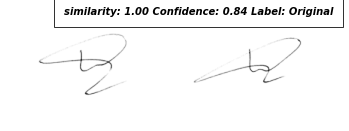

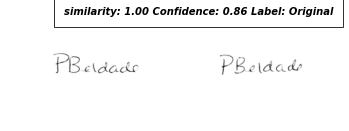

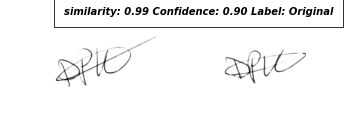

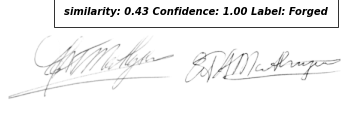

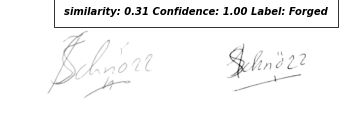

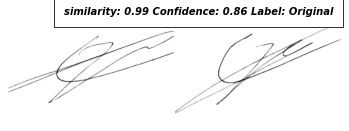

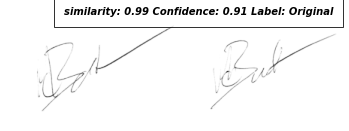

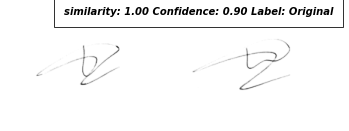

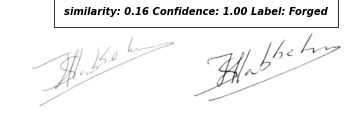

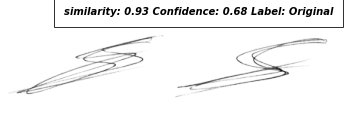

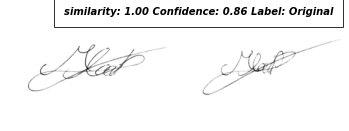

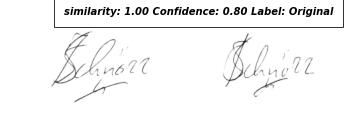

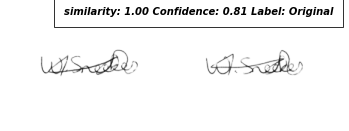

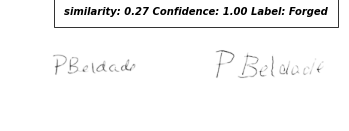

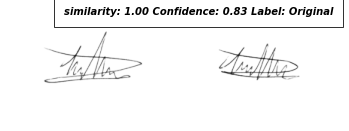

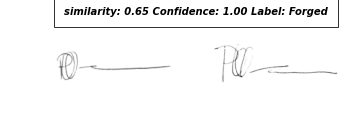

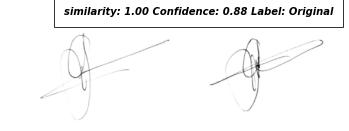

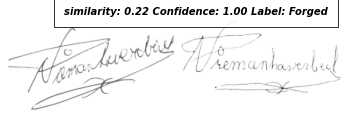

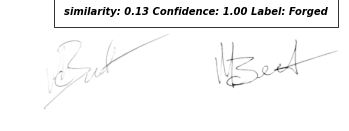

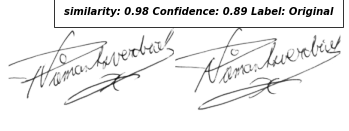

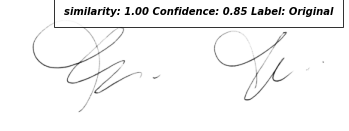

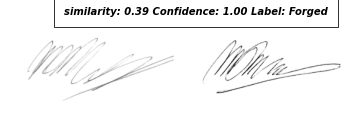

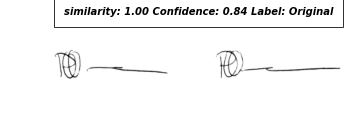

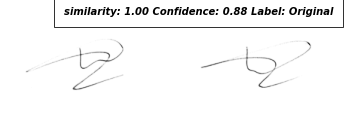

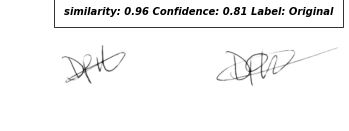

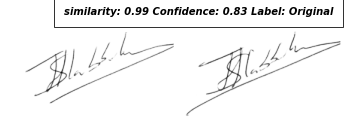

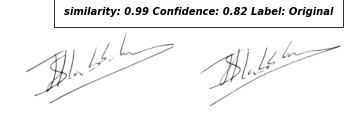

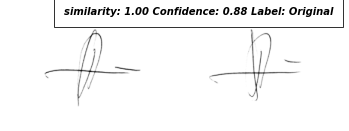

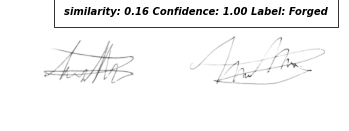

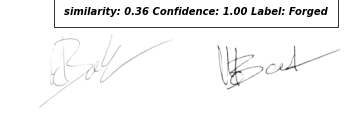

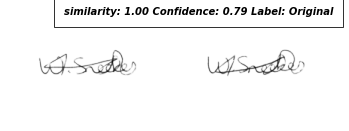

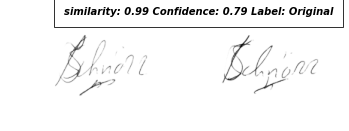

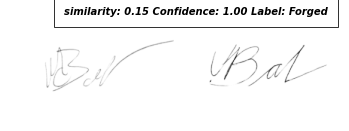

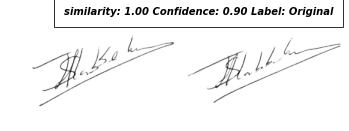

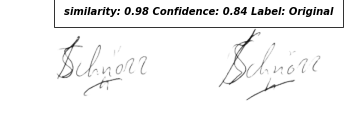

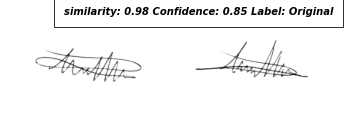

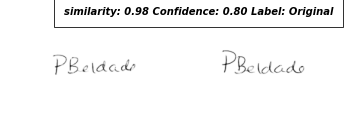

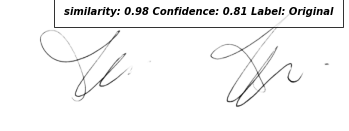

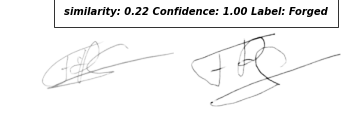

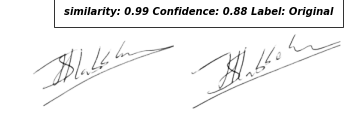

<Figure size 432x288 with 0 Axes>

In [24]:
seed_torch(seed=CFG.seed)
model = SiameseModel()
model.load_state_dict(torch.load('./convnet_best_loss.pt')['model'])


test_dataset = SignatureDataset(test, CFG.canvas_size, dim=(256, 256))

test_loader = DataLoader(test_dataset,
                              batch_size=1, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

counter = 0 
label_dict = {1.0:'Forged', 0.0:'Original'}
#CFG.projection2d=True
model.eval()
for i, data in enumerate(test_loader, 0):
    img1, img2, label = data
    concatenated = torch.cat((img1, img2),0)
    with torch.no_grad():
        op1, op2, confidence = model(img1.to('cpu'), img2.to('cpu'))
    confidence = confidence.sigmoid().detach().to('cpu')
    if label == 0.0:
        confidence = 1 - confidence
    cos_sim = F.cosine_similarity(op1, op2)

    imshow(torchvision.utils.make_grid(concatenated.unsqueeze(1)), f'similarity: {cos_sim.item():.2f} Confidence: {confidence.item():.2f} Label: {label_dict[label.item()]}')
    plt.savefig('siamese.png')
    counter+=1
    if counter==40:
        break

In [26]:
# ============================
#  CLASSIFICATION REPORT BLOCK
# ============================

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

# نقل الموديل للـ GPU (الحل النهائي للخطأ)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for img1, img2, label in test_loader:

        img1 = img1.to(device).float()
        img2 = img2.to(device).float()
        label = label.to(device)

        # forward
        op1, op2, confidence = model(img1, img2)
        confidence = confidence.sigmoid().cpu().numpy()[0][0]

        # true label
        true_label = int(label.item())   # 0 = Original, 1 = Forged
        y_true.append(true_label)

        # prediction
        pred_label = 1 if confidence >= 0.5 else 0
        y_pred.append(pred_label)

# ====== PRINT REPORT ======
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Original", "Forged"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))



Classification Report:

              precision    recall  f1-score   support

    Original       1.00      1.00      1.00      2772
      Forged       1.00      1.00      1.00      2975

    accuracy                           1.00      5747
   macro avg       1.00      1.00      1.00      5747
weighted avg       1.00      1.00      1.00      5747


Confusion Matrix:
[[2772    0]
 [   0 2975]]


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from IPython.display import HTML, display

# تحويل التقارير إلى DataFrame
report_dict = classification_report(y_true, y_pred, target_names=["Original", "Forged"], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["True Original", "True Forged"], columns=["Pred Original", "Pred Forged"])

# ===== CSS للعرض الشيك =====
style = """
<style>
    .report-box {
        background: #1e1e1e;
        padding: 20px;
        border-radius: 12px;
        color: #ffffff;
        font-family: Arial;
        margin-bottom: 20px;
        border: 1px solid #444;
    }
    .report-title {
        font-size: 24px;
        font-weight: bold;
        margin-bottom: 10px;
        color: #4CAF50;
    }
    table {
        width: 100%;
        border-collapse: collapse;
        margin-top: 12px;
        font-size: 15px;
    }
    th {
        background: #333;
        padding: 10px;
        color: #4CAF50;
        border-bottom: 2px solid #555;
    }
    td {
        padding: 8px;
        background: #2b2b2b;
        border-bottom: 1px solid #444;
        text-align: center;
    }
    tr:hover td {
        background: #3a3a3a;
    }
</style>
"""

# ===== عرض التقرير والكونفيوجن =====
html_output = f"""
<div class='report-box'>
    <div class='report-title'>📊 Classification Report</div>
    {report_df.to_html(classes="report-table")}
</div>

<div class='report-box'>
    <div class='report-title'>🧩 Confusion Matrix</div>
    {cm_df.to_html(classes="cm-table")}
</div>
"""

display(HTML(style + html_output))


In [36]:
!pip install gradio --quiet

import gradio as gr
import torch
import numpy as np
import cv2

def verify_fn(orig_img, suspect_img):

    if orig_img is None or suspect_img is None:
        return "❌ Please upload both images!"

    # تحويل الصور لـ numpy grayscale
    orig = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    sus  = cv2.cvtColor(suspect_img, cv2.COLOR_BGR2GRAY)

    # نفس preprocessing
    p1 = preprocess_signature(orig, CFG.canvas_size, (170,242), (150,220))
    p2 = preprocess_signature(sus, CFG.canvas_size, (170,242), (150,220))

    t1 = torch.tensor(p1).unsqueeze(0).to(device).float()
    t2 = torch.tensor(p2).unsqueeze(0).to(device).float()

    model.eval()
    with torch.no_grad():
        _, _, conf = model(t1, t2)
        conf = conf.sigmoid().item()

    pred = 1 if conf >= 0.5 else 0

    if pred == 1:
        return f"⚠️ FORGED — Confidence: {conf:.4f}"
    else:
        return f"✔️ ORIGINAL — Confidence: {conf:.4f}"


# واجهة جرايديو
interface = gr.Interface(
    fn=verify_fn,
    inputs=[
        gr.Image(type="numpy", label="Original Signature"),
        gr.Image(type="numpy", label="Suspect Signature")
    ],
    outputs="text",
    title="Signature Verification",
    description="Upload the original signature and the suspicious one."
)

interface.launch(debug=True)


IMPORTANT: You are using gradio version 3.34.0, however version 4.44.1 is available, please upgrade.
--------
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://56aa5e539232891675.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://56aa5e539232891675.gradio.live
